In [2]:
import numpy as np
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from datetime import date
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance
import optuna

In [3]:
train = pd.read_csv('data/train.csv', index_col = 'id')
test =  pd.read_csv('data/test.csv', index_col = 'id')
submission = pd.read_csv('data/sample_submission.csv', index_col = 'id')

# Exploratory Data Analysis

First we should check if there are any missing values in the dataset.

In [4]:
train.isna().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [5]:
test.isna().sum()

Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health Score             49449
Location                     0
Policy Type                  0
Previous Claims         242802
Vehicle Age                  3
Credit Score             91451
Insurance Duration           2
Policy Start Date            0
Customer Feedback        52276
Smoking Status               0
Exercise Frequency           0
Property Type                0
dtype: int64

As we can see, there are many missing values in most of the features, so we shouldn't cut them off from training.
Instead we are going to make new features from numerical variables, indicating whether they are missing or not.
Those new features will turn out useful in a while. For categorical features we will simply change missing values with a text *"unknown"*.

In [ ]:
num_features = ['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
                'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration']

for feature in num_features:
    train['unknown_'+feature] = 0
    train.loc[train[feature].isna(), 'unknown_'+feature] = 1
    
    test['unknown_'+feature] = 0
    test.loc[test[feature].isna(), 'unknown_'+feature] = 1


cat_features = ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
                'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

for feature in cat_features:
    train[feature] = train[feature].replace(np.nan, 'unknown')
    test[feature] = test[feature].replace(np.nan, 'unknown')

For convenience, we won't change missing values in numerical variables until later.

### Categorical Features

Now we will inspect all categorical features. We will start by checking their possible values.

In [7]:
for feature in cat_features:
    print(feature+':')
    print(train[feature].unique())

Gender:
['Female' 'Male']
Marital Status:
['Married' 'Divorced' 'Single' 'unknown']
Education Level:
["Bachelor's" "Master's" 'High School' 'PhD']
Occupation:
['Self-Employed' 'unknown' 'Employed' 'Unemployed']
Location:
['Urban' 'Rural' 'Suburban']
Policy Type:
['Premium' 'Comprehensive' 'Basic']
Customer Feedback:
['Poor' 'Average' 'Good' 'unknown']
Smoking Status:
['No' 'Yes']
Exercise Frequency:
['Weekly' 'Monthly' 'Daily' 'Rarely']
Property Type:
['House' 'Apartment' 'Condo']


As we can see, they don't have many values. That gives us a possibility to include them in the training as basic dummy features without creating too many new variables. We should analyze how categorical variables are related to the target variable **premium amount**. We will generate bar plots for each feature versus *mean* of the target variable.

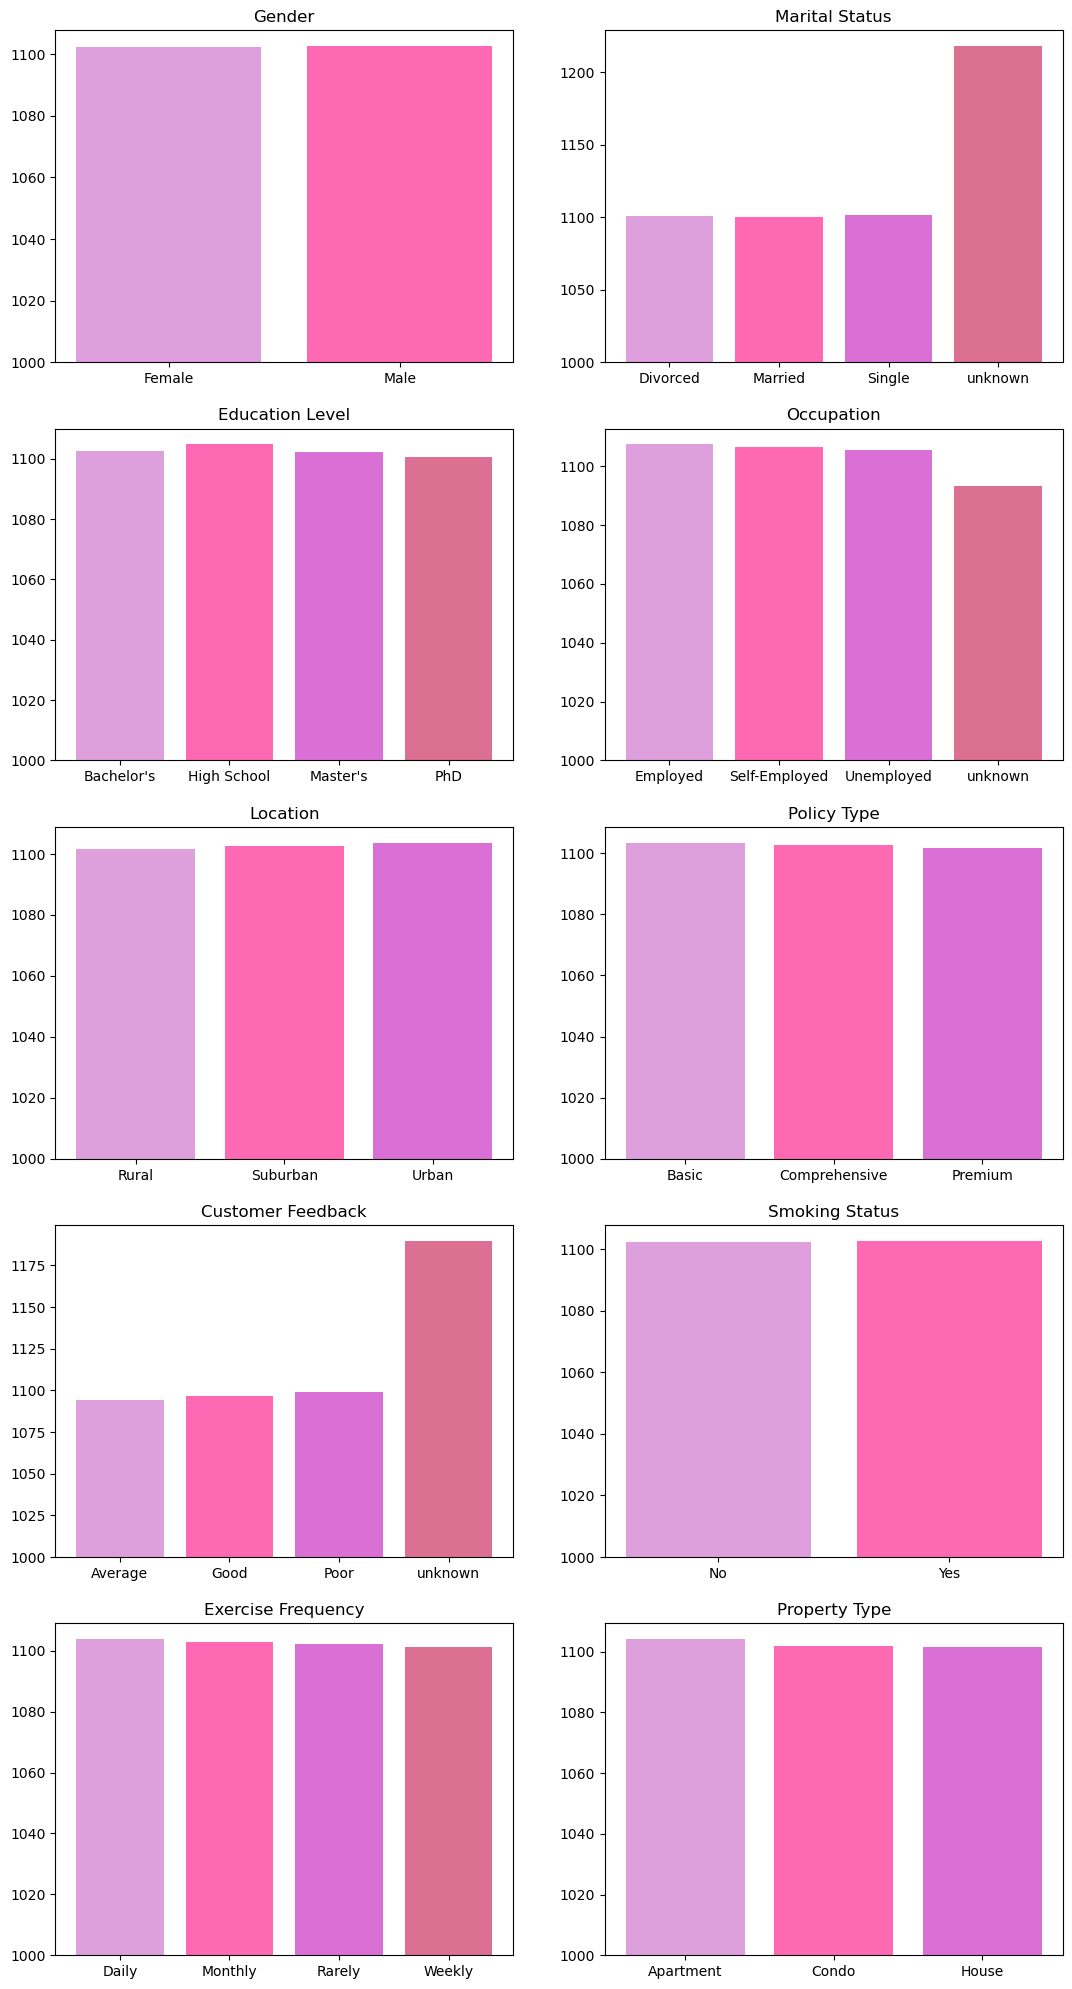

In [8]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, sharex = False, figsize = (13,25))
colors = ['plum', 'hotpink', 'orchid', 'palevioletred']

for i, feature in enumerate(cat_features):
    values = train[[feature, 'Premium Amount']].groupby(feature).mean() - 1000
    axs[i//2,i%2].set_title(feature)
    axs[i//2,i%2].bar(values.index, values['Premium Amount'], label = feature, bottom = 1000, color = colors)

For clarity we cut values by 1000. It is easy to see that all of the present features give little to no information about **premium amount**. Although the addition of **unknown** values in all of the cases where there were missing values give us a lot of information. We might suspect that it is similar with the numerical features including missing values.

Knowing that all of the categorical features give little information about the target variable, we should think about introducing extra features combining them together e.g., *Women with Master's degree that are single*. Although, we should only add relevant combinations, as it introduces a lot of new variables to the model. Those can cause overfitting and significantly extend the training time.

For 10 categorical columns if we want to analyze $n$ size combinations, we have to check $10 \choose n$ of them.
For $n = 2$ it is 45 combinations, for $n = 3$ that's already 120. So it is ineffective to test them with separate bar plots like we did before. All we need to know is if the target variable significantly changes between combinations. So we can express it with the variance of target variable means. We will only test the case, where $n = 2$, because with increase in combinations we significantly increase the number of variables in the model.

In [9]:
def combine_data_frames(df1, df2, df):
    columns = [(col1, col2) for col1 in df1.items() for col2 in df2.items()]
    combined_df = pd.DataFrame(index = df.index)
    for column1, column2 in columns:
        combined_df[column1[0]+'_combined_'+column2[0]] = column1[1]*column2[1]
    return combined_df

cat_features_subsets = list(itertools.combinations(cat_features, 2))

dummies = pd.DataFrame(index = train.index)
for feature in cat_features:
    dummies = dummies.join(pd.get_dummies(train[feature], dtype = int, prefix = feature))

In [ ]:
variances = {}

for feature1, feature2 in cat_features_subsets:
    means = []
    feature1_dummies = dummies.loc[:,[col for col in dummies.columns if feature1 in col]]
    feature2_dummies = dummies.loc[:,[col for col in dummies.columns if feature2 in col]]
    combined = combine_data_frames(feature1_dummies, feature2_dummies, dummies)
    for i in range(combined.shape[1]):
        means.append(
            train['Premium Amount'].filter(
                items = combined.loc[combined.iloc[:,i] == 1,combined.columns[i]].index,
                axis = 0).mean()
        )
        
    variances[feature1+'-'+feature2] = np.var(means)

<BarContainer object of 45 artists>

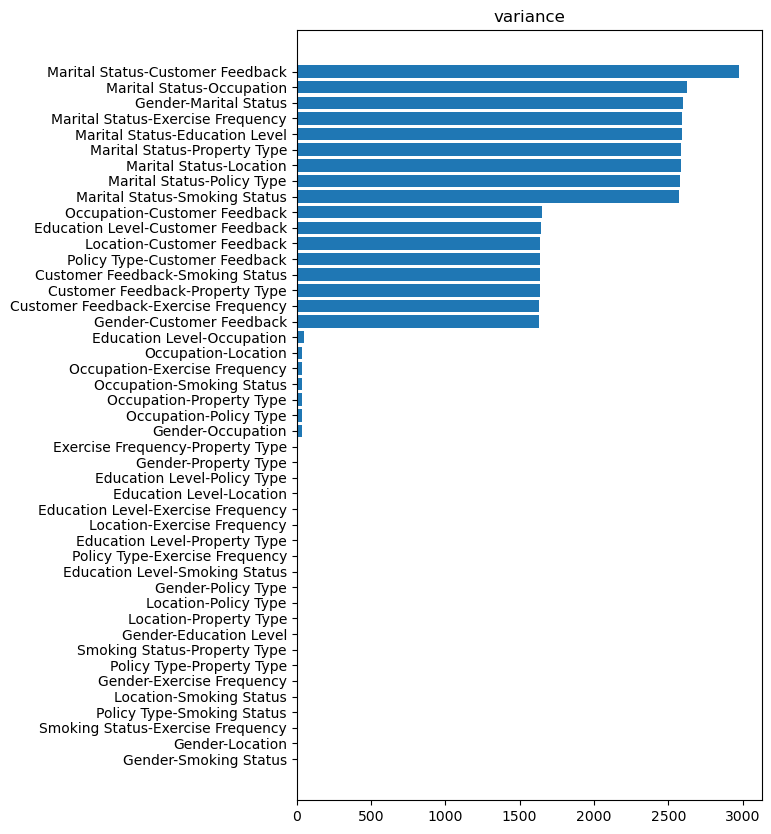

In [11]:
sorted_variances = dict(sorted(variances.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize = (6,10))

labels = list(sorted_variances.keys())
scores = list(sorted_variances.values())
ax.set_title('variance')
ax.barh(labels, scores)

As we can see, there are some combinations that introduce some change in the target variable. However, it doesn't mean they will all be significant for the target prediction. Some of the combinations might overlap with each other, making them insignificant. But it is a good start to search for new variables.

### Numerical Variables

Let's start our analysis with checking how many unique values have all numerical variables.

In [12]:
for feature in num_features:
    print("Feature", feature, "with", len(train[feature].unique()), "unique values.")

Feature Age with 48 unique values.
Feature Annual Income with 88594 unique values.
Feature Number of Dependents with 6 unique values.
Feature Health Score with 532658 unique values.
Feature Previous Claims with 11 unique values.
Feature Vehicle Age with 21 unique values.
Feature Credit Score with 551 unique values.
Feature Insurance Duration with 10 unique values.


We have 3 out of 8 numerical features, that have many unique values.

To utilize the most of the numerical features, we should use feature-combining methods. But the straightforward way that we used for categorical features is useless, because of the high cardinality of the numerical features. Instead, we will use **target encoding**, that can blend categorical features with numerical ones, creating only little extra features.

To make the best use of **target encoding** we will treat numerical features as categorical. Having 3 features with very high cardinality, we will make new features for them, by putting them inside fixed bins. This reduces the number of unique values.

In [13]:
columns = ['Annual Income', 'Health Score', 'Credit Score']
num_of_bins = [1000, 100, 500]

for bins, col in zip(num_of_bins, columns):
    train['categorical_'+col] = " "
    test['categorical_'+col] = " "

    train_without_na = train.loc[~train[col].isna(),:]
    test_without_na = test.loc[~test[col].isna(),:]
    
    space = np.linspace(int(np.floor(train_without_na[col].min())-1),
                        int(train_without_na[col].max())+1, bins)
    
    for i, floor in enumerate(space[:-1]):
        bin = train_without_na.loc[train_without_na[col].between(
              left = floor, right = space[i+1], inclusive = 'left'),:]
        
        train.loc[bin.index,'categorical_'+col] = str(floor)+'-'+str(space[i+1])

        test_bin = test_without_na.loc[test_without_na[col].between(
                   left = floor, right = space[i+1], inclusive = 'left'),:]
        
        test.loc[test_bin.index,'categorical_'+col] = str(floor)+'-'+str(space[i+1])
        
    train['categorical_'+col] = train['categorical_'+col].replace(" ", 'NA')
    test['categorical_'+col] = test['categorical_'+col].replace(" ", 'NA')

With the newly added features, we can create **target encoding** features with *mean*, *median*, *max*, *min*, *nunique* and *count* statistics. The selected pairs, that have been tested in advance, are possibly significant for the target variable. Later we will make features selection algorithm that will choose only the significant ones.

But before that, we will handle rest of the missing data, putting -1 in place of `nan` values for continuous features.

In [14]:
for feature in num_features:
    train[feature] = train[feature].replace(np.nan, -1)
    test[feature] = test[feature].replace(np.nan, -1)

Now we can check whether there are any missing values in train or test set. After that, we can create **TE** variables.

In [15]:
print(train.isna().sum().sum(), 'missing values in the train set.')
print(test.isna().sum().sum(), 'missing values in the test set.')

0 missing values in the train set.
0 missing values in the test set.


In [16]:
count_te_features = [*cat_features, 'categorical_Annual Income', 'categorical_Health Score', 'categorical_Credit Score',
                     'Age', 'Number of Dependents', 'Previous Claims', 'Vehicle Age', 'Insurance Duration']

for col in count_te_features:
    table = train.loc[:,col].value_counts(normalize = True).rename('TE_count_'+col)
    train = train.join(table, on = col)
    test = test.join(table, on = col)

TE_pairs = [['Annual Income', 'categorical_Health Score'], ['Health Score', 'categorical_Annual Income'],
            ['Credit Score', 'categorical_Annual Income'], ['Health Score', 'Customer Feedback'],
            ['Credit Score', 'categorical_Health Score'], ['Health Score', 'categorical_Credit Score'],
            ['Annual Income', 'categorical_Credit Score'], ['Health Score', 'Exercise Frequency'],
            ['Health Score', 'Marital Status'], ['Health Score', 'Occupation'], 
            ['Age', 'categorical_Health Score'], ['Health Score', 'Insurance Duration'],
            ['Health Score', 'Property Type'], ['Annual Income', 'Customer Feedback'],
            ['Credit Score', 'Customer Feedback']]

for num_col, cat_col in TE_pairs:
    table = train.loc[train[num_col] > -1,
                      [cat_col,num_col]].groupby(cat_col)[num_col].mean().rename('TE_mean_'+num_col+'-'+cat_col)
        
    train = train.join(table,on = cat_col)
    test = test.join(table,on = cat_col)
    
    table = train.loc[train[num_col] > -1,
                      [cat_col,num_col]].groupby(cat_col)[num_col].median().rename('TE_median_'+num_col+'-'+cat_col)
        
    train = train.join(table,on = cat_col)
    test = test.join(table,on = cat_col)

    table = train.loc[train[num_col] > -1,
                      [cat_col,num_col]].groupby(cat_col)[num_col].max().rename('TE_max_'+num_col+'-'+cat_col)
        
    train = train.join(table,on = cat_col)
    test = test.join(table,on = cat_col)

    table = train.loc[train[num_col] > -1,
                      [cat_col,num_col]].groupby(cat_col)[num_col].min().rename('TE_min_'+num_col+'-'+cat_col)
        
    train = train.join(table,on = cat_col)
    test = test.join(table,on = cat_col)
    
    table = train.loc[train[num_col] > -1,
                      [cat_col,num_col]].groupby(cat_col)[num_col].nunique().rename('TE_unique_'+num_col+'-'+cat_col)
        
    train = train.join(table,on = cat_col)
    test = test.join(table,on = cat_col)

### Date Time Variables

We have only one date time variable in our dataset, namely *Policy Start Date*. We will use it to extract *year*, *month* and *day* variables from it.

In [17]:
train.Age = train.Age.astype(int, errors = 'ignore')
train['Policy Start Date'] = pd.to_datetime(train['Policy Start Date'])

test.Age = test.Age.astype(int, errors = 'ignore')
test['Policy Start Date'] = pd.to_datetime(test['Policy Start Date'])

train['start_policy_year'] = train['Policy Start Date'].dt.year
train['start_policy_month'] = train['Policy Start Date'].dt.month
train['start_policy_day'] = train['Policy Start Date'].dt.day

test['start_policy_year'] = test['Policy Start Date'].dt.year
test['start_policy_month'] = test['Policy Start Date'].dt.month
test['start_policy_day'] = test['Policy Start Date'].dt.day

C:\Users\Piotr\AppData\Local\Temp\ipykernel_9956\1327233759.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['start_policy_year'] = test['Policy Start Date'].dt.year
C:\Users\Piotr\AppData\Local\Temp\ipykernel_9956\1327233759.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['start_policy_month'] = test['Policy Start Date'].dt.month
C:\Users\Piotr\AppData\Local\Temp\ipykernel_9956\1327233759.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

# Train set construction

Now, we will gather all the previous observations into a single new data frame for model training.

In [18]:
df = pd.DataFrame(index = train.index)

#numerical variables
for feature in num_features:
    df = df.join(train[feature])
    
#unknown numerical features values
for feature in num_features:
    df = df.join(train['unknown_'+feature])

#categorical dummy variables
for feature in cat_features:
    df = df.join(pd.get_dummies(train[feature], dtype = int, prefix = feature), how = 'left')
    
#categorical features combinations with the biggest variance
best_combinations = list(sorted_variances.keys())[-9:]
best_combinations = [combination.split('-') for combination in best_combinations]

for feature1, feature2 in best_combinations:
    feature1_dummies = dummies.loc[:,[col for col in dummies.columns if feature1 in col]]
    feature2_dummies = dummies.loc[:,[col for col in dummies.columns if feature2 in col]]
    combined = combine_data_frames(feature1_dummies, feature2_dummies, dummies)
    df = df.join(combined)
    
#target encoding variables
for feature in [col for col in train.columns if 'TE_' in col]:
    df = df.join(train[feature])
    
#date time features
for feature in [col for col in train.columns if 'start_policy_' in col]:
    df = df.join(train[feature])

Now we will do the same with the test data set.

In [19]:
test_df = pd.DataFrame(index = test.index)

#numerical variables
for feature in num_features:
    test_df = test_df.join(test[feature])
    
#unknown numerical features values
for feature in num_features:
    test_df = test_df.join(test['unknown_'+feature])

#categorical dummy variables
for feature in cat_features:
    test_df = test_df.join(pd.get_dummies(test[feature], dtype = int, prefix = feature), how = 'left')
    
#categorical features combinations with the biggest variance
test_dummies = pd.DataFrame(index = test.index)
for feature in cat_features:
    test_dummies = test_dummies.join(pd.get_dummies(test[feature], dtype = int, prefix = feature))
    
for feature1, feature2 in best_combinations:
    feature1_dummies = test_dummies.loc[:,[col for col in test_dummies.columns if feature1 in col]]
    feature2_dummies = test_dummies.loc[:,[col for col in test_dummies.columns if feature2 in col]]
    combined = combine_data_frames(feature1_dummies, feature2_dummies, test_dummies)
    test_df = test_df.join(combined)
    
#target encoding variables
for feature in [col for col in test.columns if 'TE_' in col]:
    test_df = test_df.join(test[feature])
    
#date time features
for feature in [col for col in test.columns if 'start_policy_' in col]:
    test_df = test_df.join(test[feature])
    
test_df = test_df.loc[:,df.columns]

Now, we should validate if everything went well and we don't have `nan` values in both data frames.

In [20]:
print(df.isna().sum().sum(), 'missing values in the train set.')
print(test_df.isna().sum().sum(), 'missing values in the test set.')

0 missing values in the train set.
0 missing values in the test set.


For optimalization, we'll change the 64-bit underlying types to 32-bit ones.

In [21]:
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
df[df.select_dtypes(np.longlong).columns] = df.select_dtypes(np.longlong).astype(np.int32)

test_df[test_df.select_dtypes(np.float64).columns] = test_df.select_dtypes(np.float64).astype(np.float32)
test_df[test_df.select_dtypes(np.longlong).columns] = test_df.select_dtypes(np.longlong).astype(np.int32)

# Model tuning

### Features selection

After gathering all the features together, we can see that there are 261 features in total. A lot of them are probably useless and can overfit our model. Thus, we should use some sort of feature selection algorithm. For efficiency we will use backward elimination technique. It is not the best one, but with such a big number of features others techniques like forward selection would take too long. The other reason is that we are going to use **XGBoost** regression model for our prediction, which can make some feature selection by itself.

We will start by splitting our dataset into train/validate sets.

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    df, np.log1p(train['Premium Amount']), train_size = 0.8, random_state = 0)

When creating target variable $y$, we used $\log(x + 1)$ transformation. We want to optimize **Root Mean Squared Logarithmic Error (RMSLE)** when training. **XGBoost** regressor optimizes **Mean Squared Error (MSE)**, so by using $log(x + 1)$ transformation we will optimize loss function equivalent to optimizing **RMSLE** with **XGBoost**.

As a starting point for backward elimination algorithm, we will train model with all the features included. Than we will use the full model's *RMSLE* to compare with "jackknifed" model's *RMSLE*.

In [23]:
params = {
        "n_estimators": 2000,
        "eval_metric": 'rmsle',
        "early_stopping_rounds": 50,
        "learning_rate": 0.03,
        "max_depth": 8
    }

model = XGBRegressor(**params)
model.fit(X_train.to_numpy(), y_train.to_numpy(), 
          eval_set = [(X_val.to_numpy(), y_val.to_numpy())], verbose = False)

pred = np.expm1(model.predict(X_val.to_numpy()))
score = mean_squared_log_error(np.expm1(y_val.to_numpy()), pred, squared = False)

In [24]:
relevant_features = df.columns.tolist()
best_score = score
threshold = 0.00001

for feature in df.columns:
    jackknife_df = df[[col for col in relevant_features if col != feature]]
    X_train, X_val, y_train, y_val = train_test_split(jackknife_df, 
                                                      np.log1p(train['Premium Amount']),
                                                      train_size = 0.8, random_state = 0)
    
    model = XGBRegressor(**params)
    model.fit(X_train.to_numpy(), y_train.to_numpy(),
              eval_set = [(X_val.to_numpy(), y_val.to_numpy())], verbose = False)
    
    pred = np.expm1(model.predict(X_val.to_numpy()))
    rmsle = mean_squared_log_error(np.expm1(y_val.to_numpy()), pred, squared = False)
    
    if (np.abs(rmsle - best_score)  <= threshold) or (best_score - rmsle > threshold):
        relevant_features.remove(feature)
        best_score = rmsle

### Model's parameters tuning

With relevant features obtained, we can reduce the training to them.
Finally, we will use **Optuna** to find the optimal parameters for **XGBoost** regression model.
We can do it with suggesting resonable intervals for numerical parameters and by giving possible values for categorical parameters. To evaluate the best set of parameters, we will use our target metric **RMSLE**.

In [28]:
X_train, X_val, y_train, y_val = train_test_split(
    df[relevant_features], np.log1p(train['Premium Amount']), train_size = 0.8, random_state = 0)

In [29]:
def objective(trial):
    params = {
        "n_estimators": 2000,
        "eval_metric": 'rmsle',
        "early_stopping_rounds": 100,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.03),
        "max_depth": trial.suggest_int("max_depth", 7, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 3, 8)
    }

    model = XGBRegressor(**params)
    model.fit(X_train.to_numpy(), y_train.to_numpy(), 
              eval_set = [(X_val.to_numpy(), y_val.to_numpy())], verbose = False)
    
    pred = np.expm1(model.predict(X_val.to_numpy()))
    rmsle = mean_squared_log_error(np.expm1(y_val.to_numpy()), pred, squared = False)
    return rmsle

In [30]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)

[I 2025-03-21 15:25:24,154] A new study created in memory with name: no-name-25c8a7a0-dabc-4ae6-b194-4d2c7bbe5478
[I 2025-03-21 15:30:15,471] Trial 0 finished with value: 1.0463187759757513 and parameters: {'learning_rate': 0.011149047999568947, 'max_depth': 7, 'subsample': 0.977881904871974, 'colsample_bytree': 0.7231439126162121, 'min_child_weight': 8}. Best is trial 0 with value: 1.0463187759757513.
[I 2025-03-21 15:32:45,464] Trial 1 finished with value: 1.0460073660649793 and parameters: {'learning_rate': 0.01940828582485729, 'max_depth': 9, 'subsample': 0.8840494690559741, 'colsample_bytree': 0.723759654460704, 'min_child_weight': 8}. Best is trial 1 with value: 1.0460073660649793.
[I 2025-03-21 15:38:00,192] Trial 2 finished with value: 1.0462880319935224 and parameters: {'learning_rate': 0.010548767484791879, 'max_depth': 7, 'subsample': 0.8516962177298628, 'colsample_bytree': 0.8034385602242523, 'min_child_weight': 6}. Best is trial 1 with value: 1.0460073660649793.
[I 2025-03

[I 2025-03-21 16:41:56,466] Trial 28 finished with value: 1.0460758361540656 and parameters: {'learning_rate': 0.015520812979190671, 'max_depth': 10, 'subsample': 0.8388477369033654, 'colsample_bytree': 0.6950457348664215, 'min_child_weight': 6}. Best is trial 25 with value: 1.0459659557078909.
[I 2025-03-21 16:46:00,309] Trial 29 finished with value: 1.045910281651577 and parameters: {'learning_rate': 0.010283520488525457, 'max_depth': 10, 'subsample': 0.978190429553011, 'colsample_bytree': 0.7555376449218961, 'min_child_weight': 8}. Best is trial 29 with value: 1.045910281651577.
[I 2025-03-21 16:49:30,744] Trial 30 finished with value: 1.0459233809580828 and parameters: {'learning_rate': 0.010336195964811773, 'max_depth': 10, 'subsample': 0.9743729662743713, 'colsample_bytree': 0.7434419486096171, 'min_child_weight': 8}. Best is trial 29 with value: 1.045910281651577.
[I 2025-03-21 16:52:47,525] Trial 31 finished with value: 1.0459750430821242 and parameters: {'learning_rate': 0.010

[I 2025-03-21 18:11:12,615] Trial 56 finished with value: 1.0462109453660504 and parameters: {'learning_rate': 0.024352482357493394, 'max_depth': 10, 'subsample': 0.8723011068347174, 'colsample_bytree': 0.8096351289848958, 'min_child_weight': 7}. Best is trial 54 with value: 1.045854437365614.
[I 2025-03-21 18:13:30,100] Trial 57 finished with value: 1.0459355737281704 and parameters: {'learning_rate': 0.013028280161079339, 'max_depth': 9, 'subsample': 0.8830018806286232, 'colsample_bytree': 0.8502185551579062, 'min_child_weight': 7}. Best is trial 54 with value: 1.045854437365614.
[I 2025-03-21 18:16:15,894] Trial 58 finished with value: 1.0459075039332124 and parameters: {'learning_rate': 0.010386950304675707, 'max_depth': 10, 'subsample': 0.8161426202396022, 'colsample_bytree': 0.8994315643406142, 'min_child_weight': 7}. Best is trial 54 with value: 1.045854437365614.
[I 2025-03-21 18:18:55,937] Trial 59 finished with value: 1.046034086667283 and parameters: {'learning_rate': 0.0110

# Final model

Taking everything into account, we will train a single model with the obtained features and parameters. This model will by used for the final prediction.

To conclude, we make a prediction on the test set and create a submission file.

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    df[relevant_features], np.log1p(train['Premium Amount']), train_size = 0.8, random_state = 0)

In [32]:
params = {
        "n_estimators": 2000,
        "eval_metric": 'rmsle',
        "early_stopping_rounds": 100}

params.update(study.best_params)

In [ ]:
model = XGBRegressor(**params)
model.fit(X_train.to_numpy(), y_train.to_numpy(), 
          eval_set = [(X_val.to_numpy(), y_val.to_numpy())], verbose = False)

pred = np.expm1(model.predict(test_df[relevant_features].to_numpy()))

submission['Premium Amount'] = pred
submission.to_csv('data/submission.csv')